In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
data = pd.read_csv("payroll.csv")

# Standardize the 'Agency Name' column to uppercase
data['Agency Name'] = data['Agency Name'].str.upper()

data.head(2)

C:\Users\Default.DESKTOP-9HQJD85\AppData\Local\Temp\ipykernel_15612\3553826195.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("payroll.csv")


,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay
0,2020,17.0,OFFICE OF EMERGENCY MANAGEMENT,BEREZIN,MIKHAIL,NaN,08/10/2015,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.0,per Annum,1820.0,84698.21,0.0,0.0,0.0
1,2020,17.0,OFFICE OF EMERGENCY MANAGEMENT,GEAGER,VERONICA,M,09/12/2016,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.0,per Annum,1820.0,84698.21,0.0,0.0,0.0


# How much of total pay budget is spent on overtime?

In [157]:
#group total regular pay and total OT by year

yearly_totals = data.groupby('Fiscal Year')[['Regular Gross Paid', 'Total OT Paid']].sum().reset_index()

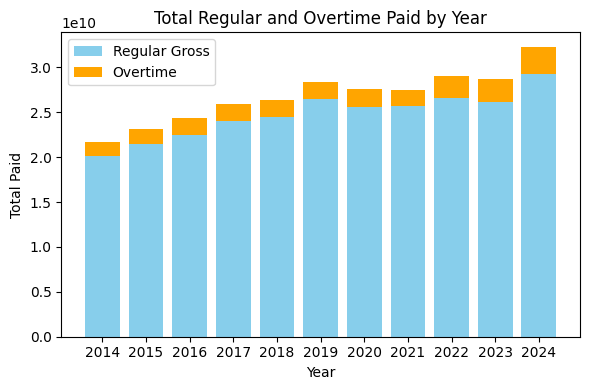

In [158]:
plt.figure(figsize=(6, 4))

plt.bar(yearly_totals['Fiscal Year'], yearly_totals['Regular Gross Paid'], label='Regular Gross', color='skyblue')
plt.bar(yearly_totals['Fiscal Year'], yearly_totals['Total OT Paid'],
        bottom=yearly_totals['Regular Gross Paid'], label='Overtime', color='orange')

plt.xlabel('Year')
plt.ylabel('Total Paid')
plt.title('Total Regular and Overtime Paid by Year')
plt.legend()
plt.xticks(yearly_totals['Fiscal Year'])

plt.tight_layout()
plt.show()

# Are certain departments consistently spending more on overtime?

In [159]:
# agg total and OT spending by year and department 
data = data[data["Total OT Paid"]>=0]
dept_yearly = data.groupby(['Fiscal Year', 'Agency Name'])[['Regular Gross Paid', 'Total OT Paid']].sum().reset_index()


In [160]:
#get total overtime percent 

dept_yearly['TotalPay'] = dept_yearly['Regular Gross Paid'] + dept_yearly['Total OT Paid']
dept_yearly['OvertimePct'] = dept_yearly['Total OT Paid'] / dept_yearly['TotalPay']

In [161]:
# now limit to the top agencies we're interested in 

top_agencies = ['DEPT OF ED PEDAGOGICAL', 'POLICE DEPARTMENT', 'FIRE DEPARTMENT',
       'DEPT OF ED PARA PROFESSIONALS', 'DEPARTMENT OF EDUCATION ADMIN',
       'DEPARTMENT OF CORRECTION', 'DEPARTMENT OF SANITATION',
       'HRA/DEPT OF SOCIAL SERVICES', 'NYC HOUSING AUTHORITY',
       'DEPT OF ENVIRONMENT PROTECTION']

dept_yearly = dept_yearly[dept_yearly["Agency Name"].isin(top_agencies)]

In [162]:
# get some stats

dept_stats = dept_yearly.groupby('Agency Name')['OvertimePct'].agg(['mean', 'std']).reset_index()
dept_stats['cv'] = dept_stats['std'] / dept_stats['mean']  # coefficient of variation

dept_stats

,Agency Name,mean,std,cv
0,DEPARTMENT OF CORRECTION,0.218476,0.054800,0.250828
1,DEPARTMENT OF EDUCATION ADMIN,0.023528,0.005330,0.226548
2,DEPARTMENT OF SANITATION,0.184419,0.043956,0.238351
3,DEPT OF ED PARA PROFESSIONALS,0.001007,0.000966,0.959181
4,DEPT OF ED PEDAGOGICAL,0.000000,0.000000,NaN
5,DEPT OF ENVIRONMENT PROTECTION,0.092009,0.011145,0.121132
6,FIRE DEPARTMENT,0.224152,0.022818,0.101798
7,HRA/DEPT OF SOCIAL SERVICES,0.067025,0.035604,0.531208
8,NYC HOUSING AUTHORITY,0.146488,0.034392,0.234777
9,POLICE DEPARTMENT,0.164322,0.021528,0.131010


Text(0.5, 1.0, 'OT/Total Pay by Dept')

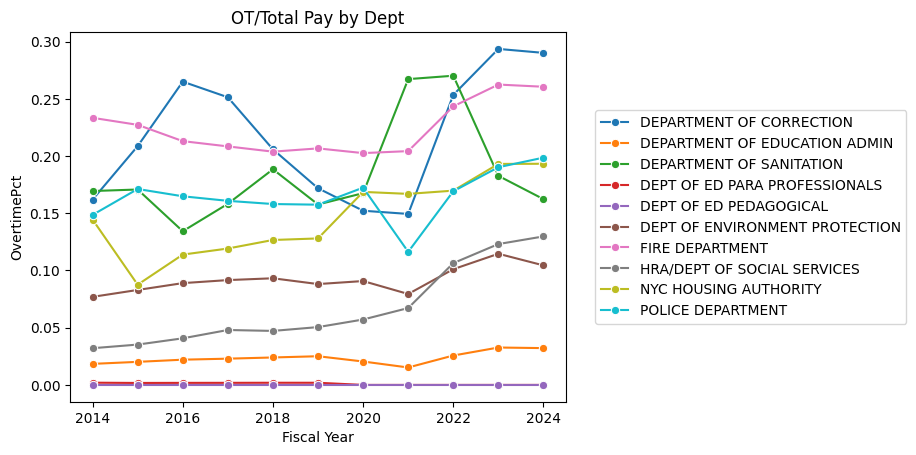

In [163]:
# now lets plot overtime spending year by year per department

sns.lineplot(data=dept_yearly, x="Fiscal Year", y="OvertimePct", hue="Agency Name", marker="o")
plt.legend(loc='right', bbox_to_anchor=(1.7, 0.5), ncol=1)

plt.title("OT/Total Pay by Dept")


# Is there a relationship between # of employees and overtime spending?

In [164]:
#number of employees by the number of records (rows) for 2022 
dept_employee_count = data.groupby(['Agency Name', "Fiscal Year"]).size().reset_index(name='num_employees')

#now get total_ot per dept in 2022, and total pay per dept in 2022
agg_data = data.groupby(['Agency Name','Fiscal Year']).agg(total_ot_hours=('Total OT Paid', 'sum'),total_reg_pay=('Regular Gross Paid', 'sum')).reset_index()


In [165]:
#merge the two so we get everything together 
agg_data = pd.merge(agg_data, dept_employee_count, on=['Agency Name','Fiscal Year'], how='inner')

#add percent overtime col
agg_data["OvertimePct"] = agg_data["total_ot_hours"]/(agg_data["total_ot_hours"] + agg_data["total_reg_pay"])
agg_data

,Agency Name,Fiscal Year,total_ot_hours,total_reg_pay,num_employees,OvertimePct
0,ADMIN FOR CHILDREN'S SVCS,2014,24403042.67,3.440385e+08,6626,0.066233
1,ADMIN FOR CHILDREN'S SVCS,2015,29319175.69,3.737270e+08,7764,0.072744
2,ADMIN FOR CHILDREN'S SVCS,2016,32364618.75,3.660777e+08,6831,0.081228
3,ADMIN FOR CHILDREN'S SVCS,2017,48867617.60,4.110463e+08,7340,0.106254
4,ADMIN FOR CHILDREN'S SVCS,2018,60584865.17,4.179034e+08,7556,0.126617
...,...,...,...,...,...,...
1106,TEACHERS RETIREMENT SYSTEM,2022,183883.33,3.071201e+07,439,0.005952
1107,TEACHERS RETIREMENT SYSTEM,2023,102295.17,3.302916e+07,467,0.003088
1108,TEACHERS RETIREMENT SYSTEM,2024,73379.64,3.688788e+07,458,0.001985
1109,TECHNOLOGY & INNOVATION,2023,1301183.08,1.546382e+08,2183,0.008344


In [174]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Model 1 : Number of employees

In [189]:
X = agg_data["num_employees"].values.reshape(-1, 1)
y = agg_data["total_ot_hours"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Using just # of employees

model1 = LinearRegression()
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)
r_squared_model1 = model1.score(X_test, y_test)
print(f"Model 1 (Number of Employees) R-squared: {r_squared_model1}")


Model 1 (Number of Employees) R-squared: 0.1719747934767628


Model 2: Agency Name

In [190]:
# One-hot encode the categorical agency name variable 
data_encoded = pd.get_dummies(agg_data, columns=['Agency Name'], drop_first=True)

# Define the independent variable (X) and dependent variable (y)
X = data_encoded.drop(columns=["Fiscal Year", "total_ot_hours","total_reg_pay","OvertimePct","num_employees"], axis=1)
y = data_encoded['total_ot_hours']  # Total overtime hours

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Model 2: Using Both Number of Employees and Department**
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Predict and evaluate Model 2
y_pred2 = model2.predict(X_test)
r_squared_model2 = model2.score(X_test, y_test)
print(f"Model 2 (Number of Employees) R-squared: {r_squared_model2}")
important_features = model2.coef_

Model 2 (Number of Employees) R-squared: 0.9703745377630658


In [188]:
coefficients = pd.DataFrame(model2.coef_, X.columns, columns=['Coefficient'])
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()

# Sort the features by absolute coefficient value
coefficients_sorted = coefficients.sort_values(by='Absolute Coefficient', ascending=False)

coefficients_sorted[:5]

,Coefficient,Absolute Coefficient
Agency Name_POLICE DEPARTMENT,7.199632e+08,7.199632e+08
Agency Name_FIRE DEPARTMENT,3.749762e+08,3.749762e+08
Agency Name_DEPARTMENT OF CORRECTION,1.734702e+08,1.734702e+08
Agency Name_DEPARTMENT OF SANITATION,1.324518e+08,1.324518e+08
Agency Name_NYC HOUSING AUTHORITY,8.056942e+07,8.056942e+07


Model 3: Num Employees + Agency Name

In [205]:
data_encoded = pd.get_dummies(agg_data, columns=['Agency Name'], drop_first=True)


X = data_encoded.drop(columns=["Fiscal Year", "total_ot_hours","total_reg_pay","OvertimePct"], axis=1)
y = data_encoded['total_ot_hours']  # Total overtime hours

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model 2: Using Both Number of Employees and Department**
model3 = LinearRegression()
model3.fit(X_train, y_train)

# Predict and evaluate Model 2
y_pred3 = model3.predict(X_test)
r_squared_model3 = model3.score(X_test, y_test)
print(f"Model 3 (Number of Employees) R-squared: {r_squared_model3}")
important_features = (model3.coef_).tolist()



Model 3 (Number of Employees) R-squared: 0.9703489956676836


In [213]:
coefficients = pd.DataFrame(model3.coef_, X.columns, columns=['Coefficient'])
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()

# Sort the features by absolute coefficient value
coefficients_sorted = coefficients.sort_values(by='Absolute Coefficient', ascending=False)

In [216]:
index_of_num_employees = coefficients_sorted.index.get_loc('num_employees')

total_features = len(coefficients_sorted)

# Calculate the index as "index out of total"
index_out_of_total = f"{index_of_num_employees + 1} out of {total_features}"

print(f"The rank of 'num_employees' is: {index_out_of_total}")


The rank of 'num_employees' is: 112 out of 115


Summary of models: Department is a more important predictor than number of employees when predicting OT hours. And department can lead to a highly accurate prediction. 

# Top Job Titles Working Overtime

In [232]:
# Group by both "Title Description" and "Department", then sum the total overtime paid
jobs_agg = data.groupby(["Title Description", "Agency Name"])["OT Hours"].sum().reset_index()

# Sort the result by "Total OT Paid"
jobs_agg_sorted = jobs_agg.sort_values(by="OT Hours", ascending=False)

print("Top 5 Job Titles by OT Hours 2012-2022")
print(jobs_agg_sorted[:5])


Top 5 Job Titles by OT Hours 2012-2022
       Title Description               Agency Name     OT Hours
6193      POLICE OFFICER         POLICE DEPARTMENT  61694804.28
5081         FIREFIGHTER           FIRE DEPARTMENT  44450310.38
3986  CORRECTION OFFICER  DEPARTMENT OF CORRECTION  34002181.01
6804   SANITATION WORKER  DEPARTMENT OF SANITATION  22011079.84
6064     P.O. DA DET GR3         POLICE DEPARTMENT  15683612.65
